In [24]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import keras_cv
import seaborn as sns
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [25]:
SEED = 42
DATA_DIR = Path().absolute().parent / "data"
DATA_PATH = DATA_DIR / "training_set.npz"
OUTPUT_DIR = DATA_DIR / "augmented"

In [26]:
RNG = np.random.default_rng(SEED)

In [27]:
with np.load(DATA_PATH) as data:
    images: np.ndarray = data["images"]
    labels: np.ndarray = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


## Cleaning

In [28]:
image_means: np.ndarray = images.mean(axis=(1, 2, 3))

In [29]:
TOLERANCE = 1e-4
MIN_DUPLICATES = 5

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

len(mean_indices.keys())

2

In [30]:
duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)
duplicated_indices.shape

(1800,)

In [31]:
original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)
original_indices.shape

(11959,)

In [32]:
clean_images = images[original_indices]
clean_labels = labels[original_indices]

print(clean_images.shape)
print(clean_labels.shape)

(11959, 96, 96, 3)
(11959, 1)


## Validation split

In [33]:
images_train, images_val, labels_train, labels_val = train_test_split(
    clean_images, clean_labels,
    test_size=.15,
    random_state=42,
    stratify=clean_labels,
)

print(images_train.shape)
print(labels_train.shape)

print(images_val.shape)
print(labels_val.shape)

(10165, 96, 96, 3)
(10165, 1)
(1794, 96, 96, 3)
(1794, 1)


In [34]:
data = {
    "train": {
        "images": images_train,
        "labels": labels_train,
    },
    "val": {
        "images": images_val,
        "labels": labels_val,
    }
}

## Rebalance

In [35]:
unique_labels, counts = np.unique(clean_labels, return_counts=True)
count_proportion = counts / counts.min()
sample_proportion = 1 / count_proportion
sample_proportion

array([0.99647887, 0.38927098, 0.78248848, 0.41905232, 1.        ,
       0.85498489, 0.36437768, 0.51673767])

In [36]:
rebalanced_data = {}
for name, set_ in data.items():
    rebalanced_image_list = []
    rebalanced_label_list = []

    _, counts = np.unique(set_["labels"], return_counts=True)
    min_count = np.min(counts)

    for label, proportion in zip(np.unique(set_["labels"]), sample_proportion):
        label_support = np.nonzero(set_["labels"] == label)[0]
        i = RNG.choice(label_support, min_count, replace=False)
        rebalanced_image_list.append(set_["images"][i])
        rebalanced_label_list.append(set_["labels"][i])
    rebalanced_data[name] = {
        "images": np.concatenate(rebalanced_image_list, axis=0),
        "labels": np.concatenate(rebalanced_label_list, axis=0),
    }
rebalanced_data

{'train': {'images': array([[[[253, 231, 195],
           [255, 232, 198],
           [255, 229, 199],
           ...,
           [214, 179, 173],
           [215, 180, 174],
           [212, 177, 171]],
  
          [[253, 229, 198],
           [250, 224, 194],
           [252, 221, 195],
           ...,
           [213, 178, 172],
           [214, 179, 173],
           [212, 177, 171]],
  
          [[240, 211, 189],
           [240, 209, 189],
           [239, 206, 188],
           ...,
           [214, 179, 173],
           [214, 179, 173],
           [217, 182, 176]],
  
          ...,
  
          [[215, 174, 181],
           [216, 175, 179],
           [215, 175, 178],
           ...,
           [199, 160, 161],
           [200, 161, 162],
           [201, 162, 163]],
  
          [[210, 178, 177],
           [212, 179, 177],
           [212, 180, 176],
           ...,
           [200, 161, 162],
           [202, 163, 164],
           [203, 164, 165]],
  
          [[214, 178, 1

<Axes: ylabel='Count'>

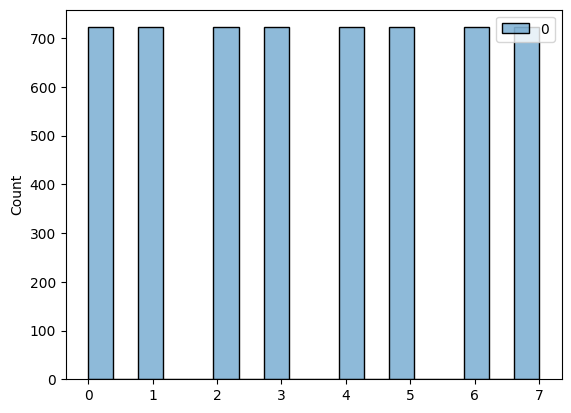

In [37]:
sns.histplot(rebalanced_data["train"]["labels"])

<Axes: ylabel='Count'>

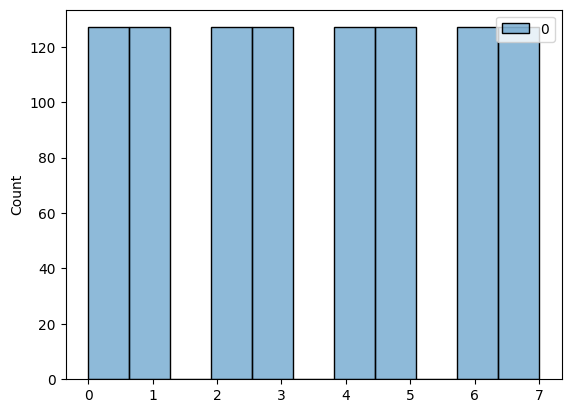

In [38]:
sns.histplot(rebalanced_data["val"]["labels"])

## Augmentation

In [39]:
def augment(dataset: tf.data.Dataset) -> tf.Tensor:
    rotation = keras_cv.layers.RandomRotation(
        1.0,
        fill_mode="constant",
        fill_value=221,
    )
    brightness = keras_cv.layers.RandomBrightness((-0.05, 0.05))
    return brightness(rotation(dataset))

In [40]:
def one_hot_encode(x, y, num_classes=8):
    return (
        x,
        tf.reshape(
            tf.cast(to_categorical(y, num_classes=num_classes), tf.uint8),
            [-1],
        )
    )

In [41]:
augmented_data: dict[str, tf.data.Dataset] = {}
for name, rebalanced_set in rebalanced_data.items():
    augmented_images = augment(rebalanced_set["images"]).numpy()
    augmented_labels = rebalanced_set["labels"]
    augmented_dataset = (
        tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
        .map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)
    )
    augmented_dataset = augmented_dataset.shuffle(augmented_dataset.cardinality())

    augmented_data[name] = augmented_dataset

In [42]:
for name, dataset in augmented_data.items():
    dataset.save(str(OUTPUT_DIR / name))

## Analysis

In [43]:
augmented_train_dataset = tf.data.Dataset.load(str(OUTPUT_DIR / "train"))
augmented_val_dataset = tf.data.Dataset.load(str(OUTPUT_DIR / "val"))

In [44]:
augmented_train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.uint8, name=None))>

In [45]:
len([sample for sample in augmented_train_dataset])

2024-11-22 20:49:10.317801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


5776

KeyboardInterrupt: 

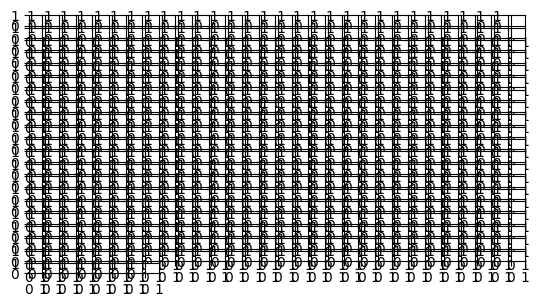

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=30, ncols=30)
axes = axes.reshape((-1))

shuffled_dataset = augmented_train_dataset.shuffle(augmented_train_dataset.cardinality())
for ax, (image, _) in zip(axes, shuffled_dataset.as_numpy_iterator()):
    ax.set_axis_off()
    ax.imshow(image / 255)

fig.subplots_adjust(wspace=0, hspace=0)